# Full changesets

## Goals
- Come up with a list of taggers that will make the model an effective flagger

## Workflow
- Download the latest 1000 reviewed changesets from osm full features
- Use the 500 (250 harmful and 250 not harmful) as the training set and the other for testing.
- For every harmful changeset, understand why it was harmful
    - Convert why the changeset was harmful into a feature
- Train a model with the feature
- Predict label for other 500 changesets

## Notes
- Try a lot of taggers - 100 or even a 1000
- What taggers when used by gabbar has the best performance

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
changesets = pd.read_csv('changesets-with-features.csv')
print('Total changesets: {}'.format(changesets.shape[0]))

changesets = changesets.dropna()
print('Changesets after dropna: {}'.format(changesets.shape[0]))

changesets.sample(5)

Total changesets: 949
Changesets after dropna: 865


,changeset_id,harmful,features_created,features_modified,features_deleted,user_id,user_name,user_changesets,user_features
272,47150407,True,1,18,1,1799626,AjBelnuovo,39219.0,463764.0
464,46720748,True,7,0,0,5457963,Dmelton,3.0,25.0
16,47453525,True,7,1,0,5580467,HectorCruz1,1.0,9.0
21,47446325,True,0,1,0,5605352,Denis Dordoigne,12.0,11.0
923,47456377,False,0,1,0,5380436,Luciente,182.0,18451.0


In [4]:
harmful_changesets = changesets[changesets['harmful'] == True]
print('Changesets harmful: {}'.format(harmful_changesets.shape))


not_harmful_changesets = changesets[changesets['harmful'] == False]
print('Changesets harmful: {}'.format(not_harmful_changesets.shape))

Changesets harmful: (423, 9)
Changesets harmful: (442, 9)


In [5]:
from sklearn.cross_validation import train_test_split

# Feature matrix.
features = [
    'features_created',
    'features_modified',
    'features_deleted',
    'user_changesets',
    'user_features',
]
X = changesets[features]

# Target array.
y = changesets['harmful']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
print('Training samples: {}'.format(Xtrain.shape[0]))
print('Testing samples: {}'.format(Xtest.shape[0]))

Training samples: 648
Testing samples: 217


/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(Xtrain, ytrain);

# Get predictions.
ymodel = model.predict(Xtest)

In [7]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ymodel))

             precision    recall  f1-score   support

      False       0.87      0.29      0.43       114
       True       0.55      0.95      0.70       103

avg / total       0.72      0.60      0.56       217



In [8]:
# Evaluate a score by cross-validation.
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(model, X, y, cv=3)
np.mean(scores)

0.58731417403562725

/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


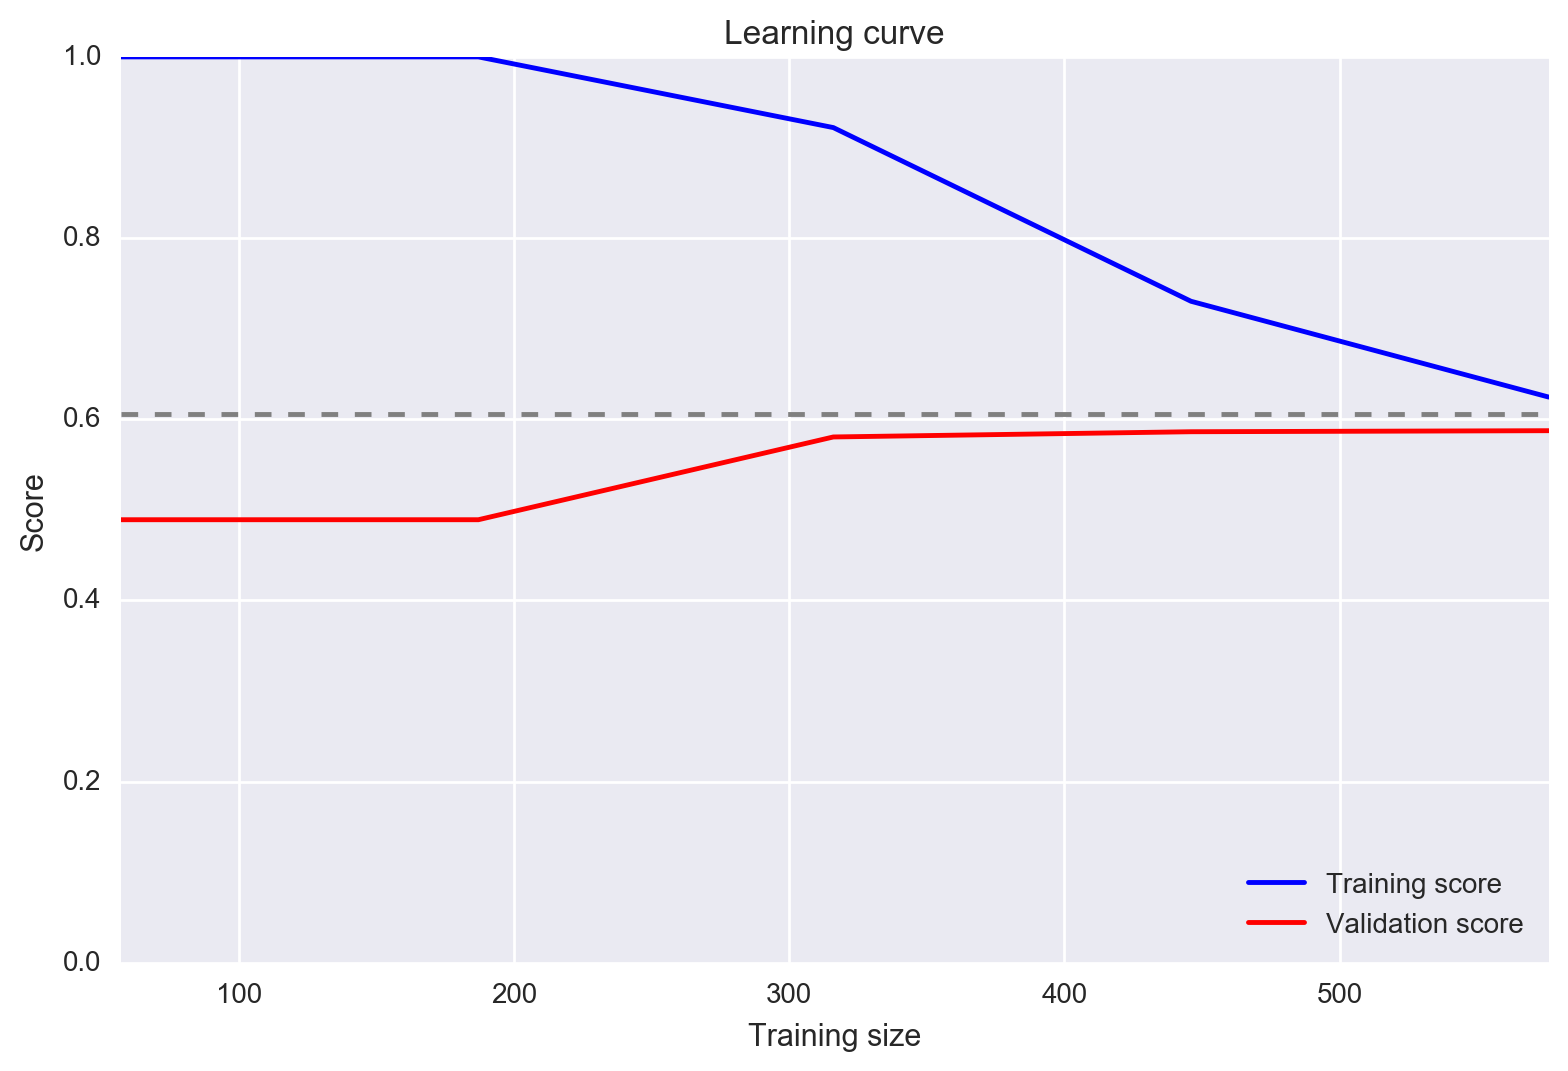

In [9]:
# Learning curve.
from sklearn.learning_curve import learning_curve

fig, ax = plt.subplots(1, 1)

N, train_lc, val_lc = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, 5))

ax.plot(N, np.mean(train_lc, 1), color='blue', label='Training score')
ax.plot(N, np.mean(val_lc, 1), color='red', label='Validation score')
ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')

ax.set_ylim(0, 1)
ax.set_xlim(N[0], N[-1])
ax.set_xlabel('Training size')
ax.set_ylabel('Score')
ax.set_title('Learning curve')
ax.legend(loc='lower right')

plt.tight_layout()

In [10]:
# Add the predictions as a new column.
changesets['prediction'] = model.predict(changesets[features])

In [11]:
from sklearn.metrics import confusion_matrix
np.ravel(confusion_matrix(changesets['harmful'], changesets['prediction']))

array([127, 315,  15, 408])

In [12]:
print('Predicted true: {}'.format(changesets[changesets['prediction'] == True].shape[0]))
print('Predicted false: {}'.format(changesets[changesets['prediction'] == False].shape[0]))

Predicted true: 723
Predicted false: 142


In [13]:
booleans = [True, False]
for actual in booleans:
    for prediction in booleans:
        temp = changesets[(changesets['harmful'] == actual) & (changesets['prediction'] == prediction)]
        print('Actual: {}, Prediction: {}, Changesets: {}'.format(actual, prediction, temp.shape[0]))

Actual: True, Prediction: True, Changesets: 408
Actual: True, Prediction: False, Changesets: 15
Actual: False, Prediction: True, Changesets: 315
Actual: False, Prediction: False, Changesets: 127


In [14]:
changesets[(changesets['harmful'] == True) & (changesets['prediction'] == False)].head()

,changeset_id,harmful,features_created,features_modified,features_deleted,user_id,user_name,user_changesets,user_features,prediction
82,47394226,True,0,2,0,360392,maxerickson,15412.0,4438829.0,False
103,47376830,True,94,311,241,5181576,Kpburns,371.0,61614.0,False
115,47376781,True,0,142,2,665748,sebastic,14784.0,3011669.0,False
126,47375211,True,0,79,2,130472,fx99,22076.0,2629075.0,False
131,47350486,True,0,97,0,290680,wheelmap_visitor,16500.0,512192.0,False
